# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg, cv
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)

test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]

healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)


In [3]:
# test
test = np.array(test)
ID_test_init = test[:,0]
X_test = test[:,2:]
y_test = test[:, 1]
y_test = y_test.reshape((-1,1))

# healthy
healthy = np.array(healthy)
y_healthy = healthy[:, 1]
X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
y_healthy = y_healthy.reshape((-1,1))


X_test_init = np.array(X_test, dtype=np.float64)
y_test_init = np.array(y_test, dtype=np.float64)


# split the healthy
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=0.5, random_state=3)
y_train_h = y_train_h.reshape((-1,1))
y_test_h = y_test_h.reshape((-1,1))
ID_train_h = X_train_h[:,0]
X_train_h = X_train_h[:,1:]
ID_test_h = X_test_h[:,0]
X_test_h = X_test_h[:,1:]
y_train_h = np.array(y_train_h, dtype=np.float64)
X_train_h = np.array(X_train_h, dtype=np.float64)
y_test_h = np.array(y_test_h, dtype=np.float64)
X_test_h = np.array(X_test_h, dtype=np.float64)
# Now add again
ID_test = np.concatenate((ID_test_init, ID_test_h))
y_test = np.concatenate((y_test_init, y_test_h))
X_test = np.concatenate((X_test_init, X_test_h))

ID_train = ID_train_h
y_train = y_train_h
X_train = X_train_h

In [4]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDNe', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=300, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

300/300 [100%] ██████████████████████████████ Elapsed: 12s | loss: 108.046
mean log-loss train: 1.4601
Test MSE: 6.136399466623428


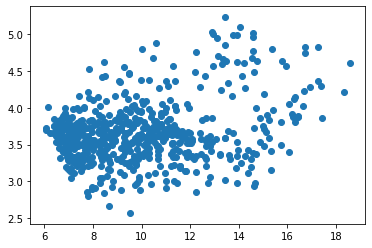

In [5]:
plt.scatter( model.mean_(X_test), model.std_(X_test))
plt.show()

In [6]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), 1+std)
#discrepancy = y_test-y_pred

In [7]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

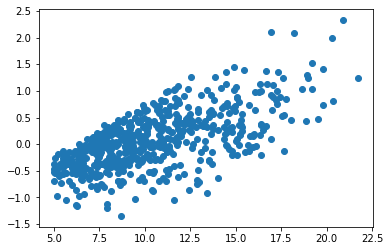

In [8]:
plt.scatter(dataframe['Age'], discrepancy)

In [9]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                       217
ADHD-Inattentive Type                                    188
No Diagnosis Given                                        74
Autism Spectrum Disorder                                  73
Specific Learning Disorder with Impairment in Reading     61
Name: DX_01, dtype: int64

In [10]:
df = dataframe
autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
inattentive = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
combined = df[df['DX_01'] == 'ADHD-Combined Type']['discrepancy']
impaired = df[df['DX_01'] == 'Specific Learning Disorder with Impairment in Reading']['discrepancy']

res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)[1]
res2 = ttest_ind(np.array(inattentive), np.array(healthy), equal_var=False)[1]
res3 = ttest_ind(np.array(combined), np.array(healthy), equal_var=False)[1]
res4 = ttest_ind(np.array(impaired), np.array(healthy), equal_var=False)[1]
p_vals = [res1, res2, res3, res4]
corrected = multipletests(pvals = p_vals, alpha=0.05, method = 'fdr_bh')
print("Autism: {}, Inattentive: {}, Combined: {}, Impaired: {}".format(corrected[1][0], corrected[1][1], corrected[1][2], corrected[1][3]))

Autism: 0.0012137420257601129, Inattentive: 3.881790278528295e-05, Combined: 0.41618929956237016, Impaired: 0.0348160983958482


## Consider the most frequent situations: ADHD Inattentive, ADHD Combined, Autism, Healthy. Specific impairment in Reading

# Visualization

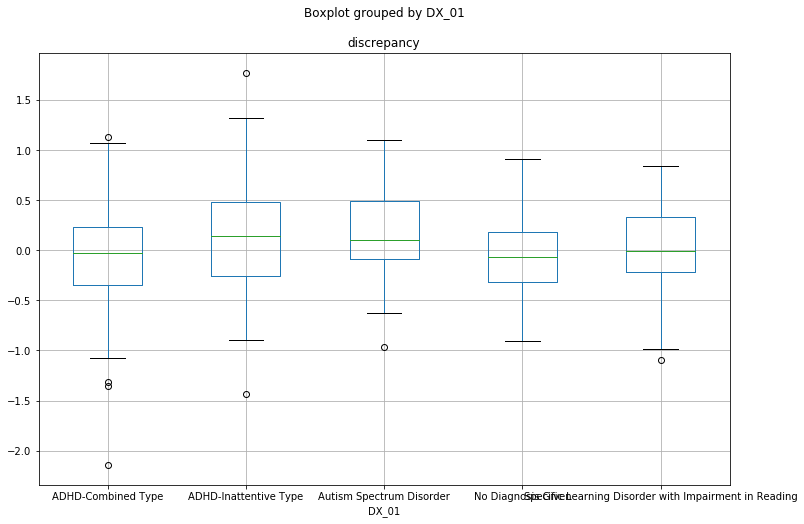

In [12]:
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

## Evaluate these quantities as an average over differen splits

In [7]:
def t_test(repetitions, balance = False, multiple_testing_correction = 'fdr_bh', aggreg = 'stouffer', test_size=0.5):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)

    test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
    healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]
    
    healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)


    # test
    test = np.array(test)
    ID_test_init = test[:,0]
    X_test = test[:,2:]
    y_test = test[:, 1]
    y_test = y_test.reshape((-1,1))

    # healthy
    healthy = np.array(healthy)
    y_healthy = healthy[:, 1]
    X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
    y_healthy = y_healthy.reshape((-1,1))

    
    X_test_init = np.array(X_test, dtype=np.float64)
    y_test_init = np.array(y_test, dtype=np.float64)

    
    # things I want to compute
    t_adhd = []
    t_adhd_combined = []
    t_autism = [] 
    t_impaired = []
    
    for i in range(repetitions):
        # split the healthy
        X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=test_size, random_state=i)
        y_train_h = y_train_h.reshape((-1,1))
        y_test_h = y_test_h.reshape((-1,1))
        ID_train_h = X_train_h[:,0]
        X_train_h = X_train_h[:,1:]
        ID_test_h = X_test_h[:,0]
        X_test_h = X_test_h[:,1:]
        y_train_h = np.array(y_train_h, dtype=np.float64)
        X_train_h = np.array(X_train_h, dtype=np.float64)
        y_test_h = np.array(y_test_h, dtype=np.float64)
        X_test_h = np.array(X_test_h, dtype=np.float64)
        # Now add again
        ID_test = np.concatenate((ID_test_init, ID_test_h))
        y_test = np.concatenate((y_test_init, y_test_h))
        X_test = np.concatenate((X_test_init, X_test_h))

        ID_train = ID_train_h
        y_train = y_train_h
        X_train = X_train_h
    
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('b{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=100, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), 1+std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0], 'brain_age':y_pred[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        df = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        
        if balance == True:
            # Correct for inbalance
            dataframe = df.sample(frac=1)
            df1 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type'])]
            df2 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type'])]
            df3 = dataframe.loc[dataframe['DX_01'].isin(['No Diagnosis Given'])]
            df4 = dataframe.loc[dataframe['DX_01'].isin(['Autism Spectrum Disorder'])]
            df5 = dataframe.loc[dataframe['DX_01'].isin(['Specific Learning Disorder with Impairment in Reading'])]
            size = min(df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0], df5.shape[0])
            df1 = df1.head(size)
            df2 = df2.head(size)
            df3 = df3.head(size)
            df4 = df4.head(size)
            df5 = df5.head(size)
            df = df1.append(df2, ignore_index=True)
            df = df.append(df3, ignore_index=True)
            df = df.append(df4, ignore_index=True)
            df = df.append(df5, ignore_index=True) 

        
        # t-test for autism vs healthy
        autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
        
        
        # t-test for inattentive vs healthy
        adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res2 = ttest_ind(np.array(adhd), np.array(healthy), equal_var=False)
        
        
        # t-test for combined vs healthy
        combined = df[df['DX_01'] == 'ADHD-Combined Type']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res3 = ttest_ind(np.array(combined), np.array(healthy), equal_var=False)

        # t-test for impaired vs healthy
        impaired = df[df['DX_01'] == 'Specific Learning Disorder with Impairment in Reading']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res4 = ttest_ind(np.array(impaired), np.array(healthy), equal_var=False)
        
        # Correct p-values for multiple-testing
        p_vals = [res1[1], res2[1], res3[1], res4[1]]
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        t_autism.append(corrected[1][0])
        t_adhd.append(corrected[1][1])
        t_adhd_combined.append(corrected[1][2])
        t_impaired.append(corrected[1][3])

        
    print('Mean t-test p-val (inattentive vs healthy): {} \n Mean t-test p-val (combined vs healthy): {} \n Mean t-test p-val (autism vs healthy): {}, \n Mean t-test p-val (impaired vs healthy): {}'.format(np.mean(t_adhd), np.mean(t_adhd_combined), np.mean(t_autism), np.mean(t_impaired)))
    return(t_autism, t_adhd, t_adhd_combined, t_impaired)

In [6]:
t_test(5)

100/100 [100%] ██████████████████████████████ Elapsed: 10s | loss: 120.221
mean log-loss train: 1.6246
100/100 [100%] ██████████████████████████████ Elapsed: 10s | loss: 129.225
mean log-loss train: 1.7463
100/100 [100%] ██████████████████████████████ Elapsed: 10s | loss: 107.018
mean log-loss train: 1.4462
100/100 [100%] ██████████████████████████████ Elapsed: 11s | loss: 108.061
mean log-loss train: 1.4603
100/100 [100%] ██████████████████████████████ Elapsed: 12s | loss: 108.559
mean log-loss train: 1.4670
Mean t-test p-val (inattentive vs healthy): 0.0003100152151611853 
 Mean t-test p-val (combined vs healthy): 0.6045581455550229 
 Mean t-test p-val (autism vs healthy): 0.0010731343004551498, 
 Mean t-test p-val (impaired vs healthy): 0.042357378308425606


([0.0002961059091577188,
  0.001196915476246888,
  0.0006451053686768995,
  0.00018231236297740734,
  0.003045232385216836],
 [2.4728607177828856e-06,
  7.977144438981792e-05,
  4.5103478623367744e-05,
  3.477378041578619e-05,
  0.0013879545116591717],
 [0.22185192722640398,
  0.6792402742174737,
  0.7611634744446865,
  0.6864024282797615,
  0.6741326236067884],
 [0.013226445215432201,
  0.031829106966355665,
  0.051190986657464826,
  0.02355926719179303,
  0.09198108551108229])

Using the Benjamini-Hochberg correction.